[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/amgp-upm/dl_course_chile/blob/main/glacier_identification.ipynb)

In [92]:
try:
  import rasterio
except ImportError:
    ! pip install rasterio
    import rasterio
import numpy as np
import matplotlib.pyplot as plt


import glob
import os

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import albumentations as A

import torch
from skimage.color import label2rgb

In [19]:
S2_UNSCALE_COEF = 10000.0
S2_SCALE_COEF = 1.0 / S2_UNSCALE_COEF
DEM_SCALE_COEF = 0.0001

### Descarga de datos

In [ ]:
! wget https://www.dropbox.com/s/3y9ekly2jawkg3r/test_set.zip
! unzip test_set.zip
! rm test_set.zip
! rm -rf ./__MACOSX

### Visualización de los datos
Los datos ha sido preprocesados y solo se han almacenado algunas bandas representativas. Los archivos están imágenes Sentinel 2 formadas por las siguientes bandas:

| Banda | Descripción |
| -- | -- |
| B1 | Blue (band 2 in S2)|
| B2 | Green  (band 3 in S2)|
| B3 | Red  (band 4 in S2)|
| B4 | Visible and Near Infrared (VNIR)  (band 8 in S2)|
| B5 | Short Wave Infrared (SWIR)  (band 11 in S2)|

Así como un Modelo Digital de Elevación (DEM), y verdad de terreno (GT) obtenida a partir de un catastro de glaciares.

Las clases disponibles son:

| Clase | Identificador |
| -- | -- |
| GLACIAR DE MONTAÑA | 1 |
| GLACIAR DE VALLE | 2 |
| GLACIAR EFLUENTE | 3 |
| GLACIAR ROCOSO | 4 |
| GLACIARETE | 5 |


In [59]:
files = glob.glob('./test_set/s2/*.tif')
files = [os.path.basename(f) for f in files]

file = files[100]

Size image: (256, 256). Channels: 5


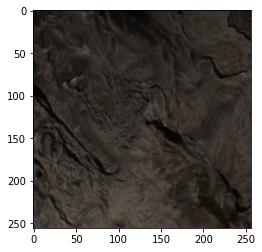

In [60]:
# Imagen Sentinel2
s2_path = f'/content/test_set/s2/{file}'
s2 = rasterio.open(s2_path)

print(f'Size image: {s2.shape}. Channels: {s2.count}')

# Cargar datos en memoria
s2_img = s2.read()

color_combination = [2, 1, 0] # Real color
plt.imshow(np.rollaxis(s2_img[color_combination] , 0, 3) * S2_SCALE_COEF)
plt.show()

Size image: (256, 256). Channels: 1


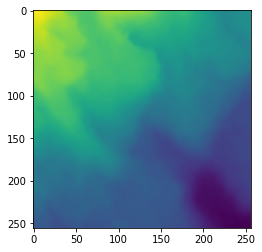

In [61]:
# DEM
dem_path = f'/content/test_set/dem/{file.replace("S2_L2A_", "DEM_")}'
dem = rasterio.open(dem_path)

print(f'Size image: {dem.shape}. Channels: {dem.count}')

# Cargar datos en memoria
dem_img = dem.read()

plt.imshow(np.squeeze(dem_img) * DEM_SCALE_COEF)
plt.show()

S2_L2A_T19HCA_20190416_5376_3200.tif
225


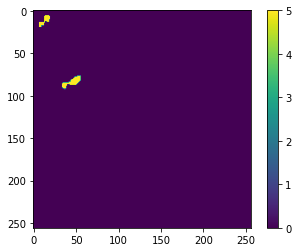

In [62]:
# GT
gt_path = f'/content/test_set/gt/{file.replace("S2_L2A_", "GT_")}'

gt = rasterio.open(gt_path)
gt = gt.read()
print(np.sum(gt!=0))
gt = np.rollaxis(gt, 0, 3)

mask = np.zeros([gt.shape[0], gt.shape[1]])
mask[gt[:, :, 0] == 1] = 1
mask[gt[:, :, 1] == 1] = 2
mask[gt[:, :, 2] == 1] = 3
mask[gt[:, :, 3] == 1] = 4
mask[gt[:, :, 4] == 1] = 5

plt.imshow(mask)
plt.colorbar()
plt.show()

### DataLoader

In [67]:
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))


In [77]:
class GlaciersDataset(Dataset):
    def __init__(self, filepath, files: np.array, transform=None) -> None:
        self.filepath = filepath
        self.samples = files
        self.transform = transform

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> dict:
        sample = self.samples[idx]

        s2 = rasterio.open(f'{self.filepath}/s2/{sample}').read() * S2_SCALE_COEF
        dem = rasterio.open(f'{self.filepath}/dem/{sample.replace("S2_L2A_", "DEM_")}').read() * DEM_SCALE_COEF
        gt = rasterio.open(f'{self.filepath}/gt/{sample.replace("S2_L2A_", "GT_")}').read()

        x = np.concatenate([s2, dem], axis=0)
        x = np.rollaxis(x, 0, 3)
        y = np.rollaxis(gt, 0, 3).astype(np.uint8)

        if self.transform:
            data = self.transform(image=x, mask=y)
            x, y = data['image'], data['mask']
        return {'image': x, 'mask': y, 'id': sample}

In [78]:
batch_size = 64
num_workers = 2
data_dir = './test_set'

X_test = glob.glob(f'{data_dir}/s2/*.tif')
X_test = [os.path.basename(f) for f in X_test]

# Tranformations
transform_test = A.Compose([A.Lambda(image=to_tensor, mask=to_tensor),])

dataset_test = GlaciersDataset(data_dir, files=X_test, 
                               transform=transform_test)

dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers)


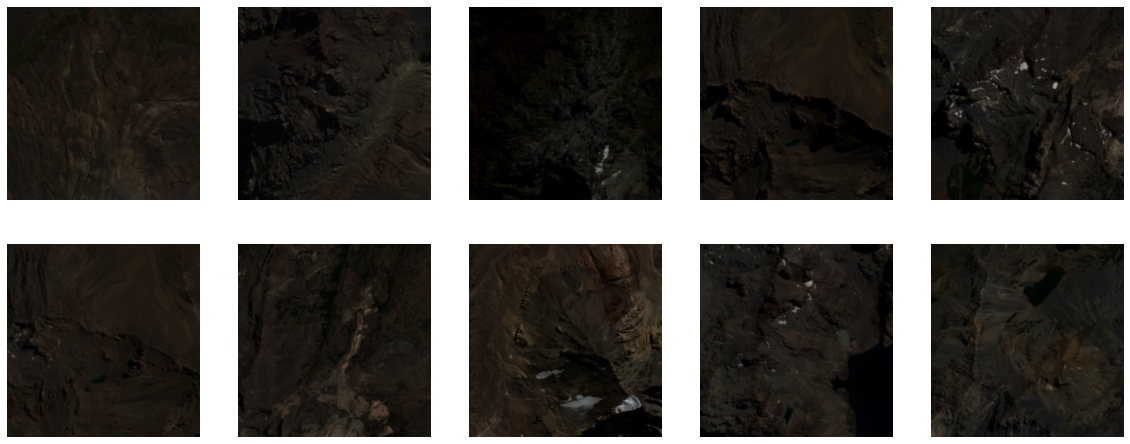

In [86]:
num_samples = 10
rand_samples = np.random.choice(batch_size, num_samples)

batch = next(iter(dataloader_test))
images = batch['image']
labels = batch['mask']
id_sample = batch['id']

fig = plt.figure(figsize=(20, 8))
for i in range(num_samples):
    image = np.squeeze(images[i][color_combination, ...].numpy())
    ax = fig.add_subplot(2, 5, i+1)
    ax.axis('off')
    ax.imshow(np.rollaxis(image, 0, 3))
plt.show()

In [89]:
# TODO: Visualizar las máscaras asociadas a cada imagen S2.
# Para ello emplear la funcion label2rgb de la libería scikit-image

### Modelo

In [93]:
class ConvBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class EncoderBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv_block = ConvBlock(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inputs):
        x = self.conv_block(inputs)
        p = self.pool(x)
        return x, p


class DecoderBlock(nn.Module):

    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.bottleneck = ConvBlock(512, 1024)
        self.decoder4 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)
        self.conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, inputs):
        e1, p1 = self.encoder1(inputs)
        e2, p2 = self.encoder2(p1)
        e3, p3 = self.encoder3(p2)
        e4, p4 = self.encoder4(p3)
        b = self.bottleneck(p4)
        d4 = self.decoder4(b, e4)
        d3 = self.decoder3(d4, e3)
        d2 = self.decoder2(d3, e2)
        d1 = self.decoder1(d2, e1)
        return self.conv(d1)

In [95]:
# Instaciar el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=6, out_channels=5).to(device)

In [97]:
# Descargar modelo preentrenado
! wget https://www.dropbox.com/s/oxlhr6t0r5ynvyo/UNET_2022-12-22_175629.ckpt

--2023-01-12 13:02:54--  https://www.dropbox.com/s/oxlhr6t0r5ynvyo/UNET_2022-12-22_175629.ckpt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/oxlhr6t0r5ynvyo/UNET_2022-12-22_175629.ckpt [following]
--2023-01-12 13:02:55--  https://www.dropbox.com/s/raw/oxlhr6t0r5ynvyo/UNET_2022-12-22_175629.ckpt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce50c4f90c66ad45f3593eeb572.dl.dropboxusercontent.com/cd/0/inline/B0Z8FW5lzY_ekNA5vGv40bhMgxpuyjgspCVslROKrLrU4DLu_vDOmH4rOoXGXw0kAbbFwhL-Wn3cQqcklKx91lKB-YfaVr-EABs_l4Q1dUl7Yxig1ogiLoROQVZNUfgQ9TnTusfaihRfk56Tv3TLgTkmAFPO8gLVzoytUOVtB9aXgw/file# [following]
--2023-01-12 13:02:56--  https://uce50c4f90c66ad45f3593eeb572.dl.dropboxusercontent.com/cd/0/inline/B0Z8FW5lzY_ekNA5vGv40bhMgxpuyjgs

In [98]:
# Cargar los pesos
ckpt = torch.load('UNET_2022-12-22_175629.ckpt')
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [99]:
# TODO: Evaluar todas las imágenes, calculando 
# las métricas vistas durante el curso. Apoyarse en la librería 
# scikit-learn